In [1]:
import pandas as pd
import random
from prepare_data import preprocess_data_czech
from eval import comapre_unidist_cont, compute_ngram_metrics, comapre_unidist_cat, compute_2d_categorical_metrics
import datetime
import calendar
import numpy as np
pd.set_option('display.max_rows', 100)

2024-03-08 11:10:24.262393: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
real = pd.read_csv('../DATA/tr_by_acct_w_age.csv')
real = real.sort_values(by = ["account_id", "date"])
raw_data, LOG_AMOUNT_SCALE, TD_SCALE = preprocess_data_czech(real)

In [3]:
all_real = raw_data[['account_id', 'tcode', 'datetime', 'amount', 'td', 'day', 'month', 'year']]
all_real['type'] = all_real['tcode'].str.split('__').str[0]
all_real['raw_amount'] = all_real.apply(lambda row: row['amount'] if row['type'] == 'CREDIT' else -row['amount'], axis=1)
all_real_cf = all_real[["account_id", "month", "raw_amount", "year"]].groupby(["account_id", "month", "year"],as_index=False)["raw_amount"].sum()


/users/fs2/hmehri/miniconda3/envs/mainenv/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/users/fs2/hmehri/miniconda3/envs/mainenv/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [4]:
all_real

,account_id,tcode,datetime,amount,td,day,month,year,type,raw_amount
0,1,CREDIT__CREDIT IN CASH__nan,1995-03-24,1000.0,0.0,24,3,1995,CREDIT,1000.0
1,1,CREDIT__COLLECTION FROM ANOTHER BANK__nan,1995-04-13,3679.0,20.0,13,4,1995,CREDIT,3679.0
2,1,CREDIT__CREDIT IN CASH__nan,1995-04-23,12600.0,10.0,23,4,1995,CREDIT,12600.0
3,1,CREDIT__nan__INTEREST CREDITED,1995-04-30,19.2,7.0,30,4,1995,CREDIT,19.2
4,1,CREDIT__COLLECTION FROM ANOTHER BANK__nan,1995-05-13,3679.0,13.0,13,5,1995,CREDIT,3679.0
...,...,...,...,...,...,...,...,...,...,...
1056315,11382,DEBIT__CASH WITHDRAWAL__nan,1998-12-02,25600.0,2.0,2,12,1998,DEBIT,-25600.0
1056316,11382,CREDIT__COLLECTION FROM ANOTHER BANK__nan,1998-12-10,46248.0,8.0,10,12,1998,CREDIT,46248.0
1056317,11382,DEBIT__CASH WITHDRAWAL__nan,1998-12-25,6300.0,15.0,25,12,1998,DEBIT,-6300.0
1056318,11382,CREDIT__nan__INTEREST CREDITED,1998-12-31,311.3,6.0,31,12,1998,CREDIT,311.3


In [4]:
rec_tcodes = ['DEBIT__CASH WITHDRAWAL__PAYMENT ON STATEMENT', 'CREDIT__nan__INTEREST CREDITED', 'DEBIT__REMITTANCE TO ANOTHER BANK__nan', 
                    'DEBIT__REMITTANCE TO ANOTHER BANK__HOUSEHOLD',  'CREDIT__COLLECTION FROM ANOTHER BANK__nan', 'DEBIT__REMITTANCE TO ANOTHER BANK__ ', 
                    'DEBIT__REMITTANCE TO ANOTHER BANK__INSURANCE PAYMENT', 'DEBIT__REMITTANCE TO ANOTHER BANK__LOAN PAYMENT', 
                     'CREDIT__COLLECTION FROM ANOTHER BANK__OLD AGE PENSION']
norec_tcodes = ['DEBIT__CASH WITHDRAWAL__ ', 'DEBIT__CASH WITHDRAWAL__nan', 
                       'DEBIT__CASH WITHDRAWAL__HOUSEHOLD', 'DEBIT__CASH WITHDRAWAL__SANCTION INTEREST',  'DEBIT__CREDIT CARD WITHDRAWAL__nan',  
                        'DEBIT__CASH WITHDRAWAL__INSURANCE PAYMENT', 'CREDIT__CREDIT IN CASH__nan']

In [5]:
rec_real = all_real[all_real['tcode'].isin(rec_tcodes)]
rec_real_cf = rec_real[["account_id", "month", "raw_amount", "year"]].groupby(["account_id", "month", "year"],as_index=False)["raw_amount"].sum()

norec_real = all_real[all_real['tcode'].isin(norec_tcodes)]
norec_real_cf = norec_real[["account_id", "month", "raw_amount", "year"]].groupby(["account_id", "month", "year"],as_index=False)["raw_amount"].sum()

In [6]:
all_real[all_real['account_id'] == 1][:100]

,account_id,tcode,datetime,amount,td,day,month,year,type,raw_amount
0,1,CREDIT__CREDIT IN CASH__nan,1995-03-24,1000.0,0.0,24,3,1995,CREDIT,1000.0
1,1,CREDIT__COLLECTION FROM ANOTHER BANK__nan,1995-04-13,3679.0,20.0,13,4,1995,CREDIT,3679.0
2,1,CREDIT__CREDIT IN CASH__nan,1995-04-23,12600.0,10.0,23,4,1995,CREDIT,12600.0
3,1,CREDIT__nan__INTEREST CREDITED,1995-04-30,19.2,7.0,30,4,1995,CREDIT,19.2
4,1,CREDIT__COLLECTION FROM ANOTHER BANK__nan,1995-05-13,3679.0,13.0,13,5,1995,CREDIT,3679.0
5,1,CREDIT__CREDIT IN CASH__nan,1995-05-23,2100.0,10.0,23,5,1995,CREDIT,2100.0
6,1,CREDIT__nan__INTEREST CREDITED,1995-05-31,79.0,8.0,31,5,1995,CREDIT,79.0
7,1,CREDIT__COLLECTION FROM ANOTHER BANK__nan,1995-06-13,3679.0,13.0,13,6,1995,CREDIT,3679.0
8,1,DEBIT__CASH WITHDRAWAL__nan,1995-06-22,200.0,9.0,22,6,1995,DEBIT,-200.0
9,1,CREDIT__nan__INTEREST CREDITED,1995-06-30,100.6,8.0,30,6,1995,CREDIT,100.6


In [7]:
rec_real[rec_real['account_id'] == 1][:100]

,account_id,tcode,datetime,amount,td,day,month,year,type,raw_amount
1,1,CREDIT__COLLECTION FROM ANOTHER BANK__nan,1995-04-13,3679.0,20.0,13,4,1995,CREDIT,3679.0
3,1,CREDIT__nan__INTEREST CREDITED,1995-04-30,19.2,7.0,30,4,1995,CREDIT,19.2
4,1,CREDIT__COLLECTION FROM ANOTHER BANK__nan,1995-05-13,3679.0,13.0,13,5,1995,CREDIT,3679.0
6,1,CREDIT__nan__INTEREST CREDITED,1995-05-31,79.0,8.0,31,5,1995,CREDIT,79.0
7,1,CREDIT__COLLECTION FROM ANOTHER BANK__nan,1995-06-13,3679.0,13.0,13,6,1995,CREDIT,3679.0
9,1,CREDIT__nan__INTEREST CREDITED,1995-06-30,100.6,8.0,30,6,1995,CREDIT,100.6
10,1,CREDIT__COLLECTION FROM ANOTHER BANK__nan,1995-07-13,3679.0,13.0,13,7,1995,CREDIT,3679.0
12,1,CREDIT__nan__INTEREST CREDITED,1995-07-31,108.9,9.0,31,7,1995,CREDIT,108.9
13,1,CREDIT__COLLECTION FROM ANOTHER BANK__nan,1995-08-13,3679.0,13.0,13,8,1995,CREDIT,3679.0
15,1,DEBIT__CASH WITHDRAWAL__PAYMENT ON STATEMENT,1995-08-31,14.6,10.0,31,8,1995,DEBIT,-14.6


In [7]:
norec_real

,account_id,tcode,datetime,amount,td,day,month,year,type,raw_amount
0,1,CREDIT__CREDIT IN CASH__nan,1995-03-24,1000.0,0.0,24,3,1995,CREDIT,1000.0
2,1,CREDIT__CREDIT IN CASH__nan,1995-04-23,12600.0,10.0,23,4,1995,CREDIT,12600.0
5,1,CREDIT__CREDIT IN CASH__nan,1995-05-23,2100.0,10.0,23,5,1995,CREDIT,2100.0
8,1,DEBIT__CASH WITHDRAWAL__nan,1995-06-22,200.0,9.0,22,6,1995,DEBIT,-200.0
11,1,DEBIT__CASH WITHDRAWAL__nan,1995-07-22,5300.0,9.0,22,7,1995,DEBIT,-5300.0
...,...,...,...,...,...,...,...,...,...,...
1056304,11382,DEBIT__CASH WITHDRAWAL__nan,1998-10-03,23000.0,3.0,3,10,1998,DEBIT,-23000.0
1056306,11382,DEBIT__CASH WITHDRAWAL__nan,1998-10-14,9000.0,4.0,14,10,1998,DEBIT,-9000.0
1056310,11382,DEBIT__CASH WITHDRAWAL__nan,1998-11-02,18900.0,2.0,2,11,1998,DEBIT,-18900.0
1056315,11382,DEBIT__CASH WITHDRAWAL__nan,1998-12-02,25600.0,2.0,2,12,1998,DEBIT,-25600.0


In [8]:
all_synthbf = pd.read_csv('../Banksformer/synth_banksformer_type1_clock.csv')
all_synthbf.rename(columns={'days_passed': 'td', 'date':'datetime'}, inplace=True)
all_synthbf['type'] = all_synthbf['tcode'].str.split('__').str[0]
all_synthbf['raw_amount'] = all_synthbf.apply(lambda row: row['amount'] if row['type'] == 'CREDIT' else -row['amount'], axis=1)
all_synthbf_cf = all_synthbf[["account_id", "month", "raw_amount", "year"]].groupby(["account_id", "month", "year"],as_index=False)["raw_amount"].sum()



In [9]:
rec_synthbf = all_synthbf[all_synthbf['tcode'].isin(rec_tcodes)]
rec_synthbf_cf = rec_synthbf[["account_id", "month", "raw_amount", "year"]].groupby(["account_id", "month", "year"],as_index=False)["raw_amount"].sum()

norec_synthbf = all_synthbf[all_synthbf['tcode'].isin(norec_tcodes)]
norec_synthbf_cf = norec_synthbf[["account_id", "month", "raw_amount", "year"]].groupby(["account_id", "month", "year"],as_index=False)["raw_amount"].sum()

In [10]:
all_synthlstm = pd.read_csv('../lstmModel/synth_lstm_type1_clock.csv')
all_synthlstm.rename(columns={'days_passed': 'td', 'date':'datetime', 'transaction_code': 'tcode'}, inplace=True)
all_synthlstm['type'] = all_synthlstm['tcode'].str.split('__').str[0]
all_synthlstm['raw_amount'] = all_synthlstm.apply(lambda row: row['amount'] if row['type'] == 'CREDIT' else -row['amount'], axis=1)
all_synthlstm_cf = all_synthbf[["account_id", "month", "raw_amount", "year"]].groupby(["account_id", "month", "year"],as_index=False)["raw_amount"].sum()


In [11]:
rec_synthlstm = all_synthlstm[all_synthlstm['tcode'].isin(rec_tcodes)]
rec_synthlstm_cf = rec_synthlstm[["account_id", "month", "raw_amount", "year"]].groupby(["account_id", "month", "year"],as_index=False)["raw_amount"].sum()

norec_synthlstm = all_synthlstm[all_synthlstm['tcode'].isin(norec_tcodes)]
norec_synthlstm_cf = norec_synthlstm[["account_id", "month", "raw_amount", "year"]].groupby(["account_id", "month", "year"],as_index=False)["raw_amount"].sum()

In [12]:
all_synthgan = pd.read_csv('../DATA/synth_ctgan_type1_clock_trans.csv')
all_synthgan.drop('td', axis=1, inplace=True)
all_synthgan['date'] = pd.to_datetime(all_synthgan['date'])
all_synthgan['month'] = all_synthgan['date'].dt.month
all_synthgan['year'] = all_synthgan['date'].dt.year
all_synthgan['day'] = all_synthgan['date'].dt.day
all_synthgan["td"] = all_synthgan[["account_id", "date"]].groupby("account_id").diff()
all_synthgan["td"] = all_synthgan["td"].apply(lambda x: x.days)
all_synthgan["td"].fillna(0.0, inplace=True)

all_synthgan.rename(columns={'date':'datetime', 'log_amount_sc':'amount'}, inplace=True)
all_synthgan['type'] = all_synthgan['tcode'].str.split('__').str[0]
all_synthgan['raw_amount'] = all_synthgan.apply(lambda row: row['amount'] if row['type'] == 'CREDIT' else -row['amount'], axis=1)
all_synthgan_cf = all_synthgan[["account_id", "month", "raw_amount", "year"]].groupby(["account_id", "month", "year"],as_index=False)["raw_amount"].sum()


In [13]:
rec_synthgan = all_synthgan[all_synthgan['tcode'].isin(rec_tcodes)]
rec_synthgan_cf = rec_synthgan[["account_id", "month", "raw_amount", "year"]].groupby(["account_id", "month", "year"],as_index=False)["raw_amount"].sum()

norec_synthgan = all_synthgan[all_synthgan['tcode'].isin(norec_tcodes)]
norec_synthgan_cf = norec_synthgan[["account_id", "month", "raw_amount", "year"]].groupby(["account_id", "month", "year"],as_index=False)["raw_amount"].sum()

In [14]:
cf_rec_synthbf = rec_synthbf_cf['raw_amount']
cf_rec_synthlstm = rec_synthlstm_cf['raw_amount']
cf_rec_real = rec_real_cf['raw_amount']
cf_rec_synthgan = rec_synthgan_cf['raw_amount']


cf_norec_synthbf = norec_synthbf_cf['raw_amount']
cf_norec_synthlstm = norec_synthlstm_cf['raw_amount']
cf_norec_real = norec_real_cf['raw_amount']
cf_norec_synthgan = norec_synthgan_cf['raw_amount']


tcode_rec_real = rec_real['tcode'].value_counts().sort_values(ascending=False)
tcode_rec_synthbf = rec_synthbf['tcode'].value_counts().reindex(tcode_rec_real.index, fill_value=0)
tcode_rec_synthlstm = rec_synthlstm['tcode'].value_counts().reindex(tcode_rec_real.index, fill_value=0)
tcode_rec_synthgan = rec_synthgan['tcode'].value_counts().reindex(tcode_rec_real.index, fill_value=0)

tcode_rec_real_norm = tcode_rec_real / tcode_rec_real.sum()
tcode_rec_synthbf_norm = tcode_rec_synthbf / tcode_rec_synthbf.sum()
tcode_rec_synthlstm_norm = tcode_rec_synthlstm / tcode_rec_synthlstm.sum()
tcode_rec_synthgan_norm = tcode_rec_synthgan / tcode_rec_synthgan.sum()


tcode_norec_real = norec_real['tcode'].value_counts().sort_values(ascending=False)
tcode_norec_synthbf = norec_synthbf['tcode'].value_counts().reindex(tcode_norec_real.index, fill_value=0)
tcode_norec_synthlstm = norec_synthlstm['tcode'].value_counts().reindex(tcode_norec_real.index, fill_value=0)
tcode_norec_synthgan = norec_synthgan['tcode'].value_counts().reindex(tcode_norec_real.index, fill_value=0)

tcode_norec_real_norm = tcode_norec_real / tcode_norec_real.sum()
tcode_norec_synthbf_norm = tcode_norec_synthbf / tcode_norec_synthbf.sum()
tcode_norec_synthlstm_norm = tcode_norec_synthlstm / tcode_norec_synthlstm.sum()
tcode_norec_synthgan_norm = tcode_norec_synthgan / tcode_norec_synthgan.sum()


amt_rec_synthbf = np.log10(rec_synthbf['amount'] + 1)
amt_rec_synthlstm = np.log10(rec_synthlstm['amount']+ 1)
amt_rec_real = np.log10(rec_real['amount']+ 1)
amt_rec_synthgan = np.log10(rec_synthgan['amount']+ 1)

amt_norec_synthbf = np.log10(norec_synthbf['amount'] + 1)
amt_norec_synthlstm = np.log10(norec_synthlstm['amount']+ 1)
amt_norec_real = np.log10(norec_real['amount']+ 1)
amt_norec_synthgan = np.log10(norec_synthgan['amount']+ 1)



In [19]:
norec_synthgan['tcode'].unique()

array(['DEBIT__CASH WITHDRAWAL__nan', 'DEBIT__CASH WITHDRAWAL__ ',
       'DEBIT__CASH WITHDRAWAL__HOUSEHOLD',
       'DEBIT__CASH WITHDRAWAL__SANCTION INTEREST',
       'DEBIT__CREDIT CARD WITHDRAWAL__nan',
       'DEBIT__CASH WITHDRAWAL__INSURANCE PAYMENT',
       'CREDIT__CREDIT IN CASH__nan'], dtype=object)

In [21]:
norec_synthgan

,amount,tcode,datetime,account_id,month,year,day,td,type,raw_amount
1,18940.82,DEBIT__CASH WITHDRAWAL__nan,1996-12-19,0,12,1996,19,6.0,DEBIT,-18940.82
2,24364.50,DEBIT__CASH WITHDRAWAL__nan,1996-12-20,0,12,1996,20,1.0,DEBIT,-24364.50
3,1449.04,DEBIT__CASH WITHDRAWAL__,1997-01-07,0,1,1997,7,18.0,DEBIT,-1449.04
4,4119.75,DEBIT__CASH WITHDRAWAL__nan,1997-01-08,0,1,1997,8,1.0,DEBIT,-4119.75
7,7520.74,DEBIT__CASH WITHDRAWAL__nan,1997-01-17,0,1,1997,17,2.0,DEBIT,-7520.74
...,...,...,...,...,...,...,...,...,...,...
399987,1461.62,DEBIT__CREDIT CARD WITHDRAWAL__nan,1997-01-02,4999,1,1997,2,0.0,DEBIT,-1461.62
399991,7243.55,DEBIT__CASH WITHDRAWAL__nan,1997-01-31,4999,1,1997,31,18.0,DEBIT,-7243.55
399992,3172.12,DEBIT__CREDIT CARD WITHDRAWAL__nan,1997-02-12,4999,2,1997,12,12.0,DEBIT,-3172.12
399993,5918.71,DEBIT__CREDIT CARD WITHDRAWAL__nan,1997-02-15,4999,2,1997,15,3.0,DEBIT,-5918.71


In [20]:
norec_synthgan[norec_synthgan['tcode'] == 'CREDIT__CREDIT IN CASH__nan']

,amount,tcode,datetime,account_id,month,year,day,td,type,raw_amount
51286,1110.85,CREDIT__CREDIT IN CASH__nan,1995-04-28,641,4,1995,28,8.0,CREDIT,1110.85
192662,1078.17,CREDIT__CREDIT IN CASH__nan,1997-01-01,2408,1,1997,1,31.0,CREDIT,1078.17
362624,25954.90,CREDIT__CREDIT IN CASH__nan,1997-02-12,4532,2,1997,12,1.0,CREDIT,25954.90
380651,18169.01,CREDIT__CREDIT IN CASH__nan,1995-03-12,4758,3,1995,12,9.0,CREDIT,18169.01


In [16]:
cf_norec_synthgan

0       -47503.37
1       -37170.27
2       -55063.18
3        -3570.97
4        -5746.77
           ...   
61097    -5376.18
61098   -18045.39
61099   -17187.87
61100    -2407.59
61101   -15933.32
Name: raw_amount, Length: 61102, dtype: float64

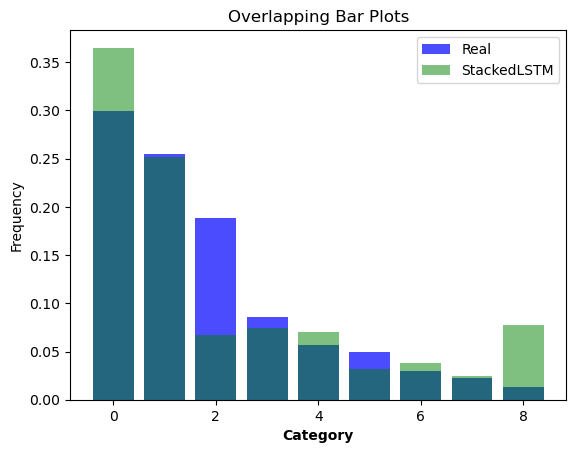

In [14]:
import matplotlib.pyplot as plt
# Calculate the counts of each category for each DataFrame
tcode_rec_real = rec_real['tcode'].value_counts().sort_values(ascending=False)
tcode_rec_synthbf = rec_synthbf['tcode'].value_counts().reindex(tcode_rec_real.index, fill_value=0)
tcode_rec_synthlstm = rec_synthlstm['tcode'].value_counts().reindex(tcode_rec_real.index, fill_value=0)
tcode_rec_synthgan = rec_synthgan['tcode'].value_counts().reindex(tcode_rec_real.index, fill_value=0)

tcode_rec_real_norm = tcode_rec_real / tcode_rec_real.sum()
tcode_rec_synthbf_norm = tcode_rec_synthbf / tcode_rec_synthbf.sum()
tcode_rec_synthlstm_norm = tcode_rec_synthlstm / tcode_rec_synthlstm.sum()
tcode_rec_synthgan_norm = tcode_rec_synthgan / tcode_rec_synthgan.sum()

# The x position of bars
positions = np.arange(len(tcode_rec_real))

# Create the bar plots with some transparency
plt.bar(positions, tcode_rec_real_norm, alpha=0.7, color='blue', label='Real')
plt.bar(positions, tcode_rec_synthlstm_norm, alpha=0.5, color='green', label='StackedLSTM')
#plt.bar(positions, tcode_rec_synthgan_norm, alpha=0.9, color='gray', label='BankGAN')
#plt.bar(positions, tcode_rec_synthbf_norm, alpha=0.7, color='red', label='Banksformer')



# Add labels, legend, and title
plt.xlabel('Category', fontweight='bold')
#plt.xticks(positions, tcode_rec_real.index)
plt.ylabel('Frequency')
plt.title('Overlapping Bar Plots')

plt.legend()

# Show the plot
plt.show()

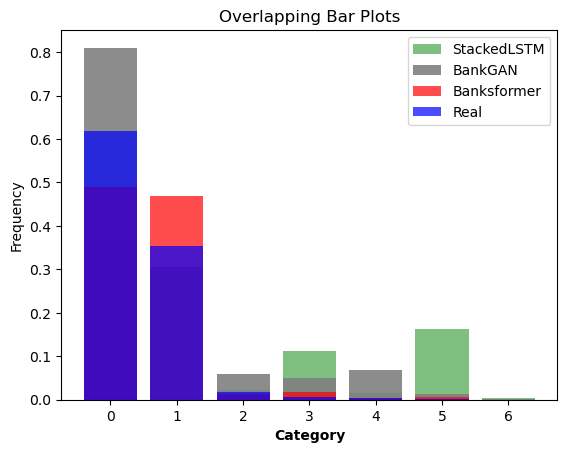

In [15]:
import matplotlib.pyplot as plt
# Calculate the counts of each category for each DataFrame
tcode_norec_real = norec_real['tcode'].value_counts().sort_values(ascending=False)
tcode_norec_synthbf = norec_synthbf['tcode'].value_counts().reindex(tcode_norec_real.index, fill_value=0)
tcode_norec_synthlstm = norec_synthlstm['tcode'].value_counts().reindex(tcode_norec_real.index, fill_value=0)
tcode_norec_synthgan = norec_synthgan['tcode'].value_counts().reindex(tcode_norec_real.index, fill_value=0)

tcode_norec_real_norm = tcode_norec_real / tcode_norec_real.sum()
tcode_norec_synthbf_norm = tcode_norec_synthbf / tcode_norec_synthbf.sum()
tcode_norec_synthlstm_norm = tcode_norec_synthlstm / tcode_norec_synthlstm.sum()
tcode_norec_synthgan_norm = tcode_norec_synthgan / tcode_norec_synthgan.sum()

# The x position of bars
positions = np.arange(len(tcode_norec_real))

# Create the bar plots with some transparency
plt.bar(positions, tcode_norec_synthlstm_norm, alpha=0.5, color='green', label='StackedLSTM')
plt.bar(positions, tcode_norec_synthgan_norm, alpha=0.9, color='gray', label='BankGAN')
plt.bar(positions, tcode_norec_synthbf_norm, alpha=0.7, color='red', label='Banksformer')

plt.bar(positions, tcode_norec_real_norm, alpha=0.7, color='blue', label='Real')



# Add labels, legend, and title
plt.xlabel('Category', fontweight='bold')
#plt.xticks(positions, tcode_rec_real.index)
plt.ylabel('Frequency')
plt.title('Overlapping Bar Plots')

plt.legend()

# Show the plot
plt.show()

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter



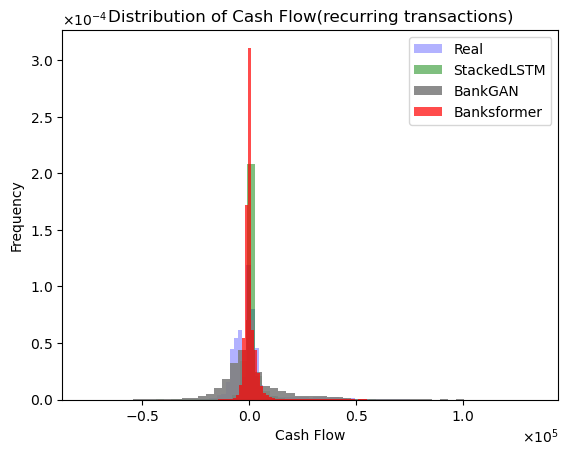

In [17]:
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

cf_rec_synthbf = rec_synthbf_cf['raw_amount']
cf_rec_synthlstm = rec_synthlstm_cf['raw_amount']
cf_rec_real = rec_real_cf['raw_amount']
cf_rec_synthgan = rec_synthgan_cf['raw_amount']


# Plot histograms
plt.hist(all_real , bins=50, alpha=0.3, color='blue', density=True, label='Real')
plt.hist(cf_rec_synthlstm, bins=50, alpha=0.5, color='green', density=True, label='StackedLSTM')
plt.hist(cf_rec_synthgan, bins=50, alpha=0.9, color='gray', density=True, label='BankGAN')
plt.hist(cf_rec_synthbf, bins=50, alpha=0.7, color='red', density=True, label='Banksformer')

# Set the formatter for the x and y axes
x_formatter = ScalarFormatter(useMathText=True)
x_formatter.set_scientific(True)
x_formatter.set_powerlimits((-3,3))

y_formatter = ScalarFormatter(useMathText=True)
y_formatter.set_scientific(True)
y_formatter.set_powerlimits((-3,3))

plt.gca().xaxis.set_major_formatter(x_formatter)
plt.gca().yaxis.set_major_formatter(y_formatter)

# Axis labels, legend, and title
plt.xlabel('Cash Flow')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.title('Distribution of Cash Flow(recurring transactions)')

# Show the plot
plt.show()


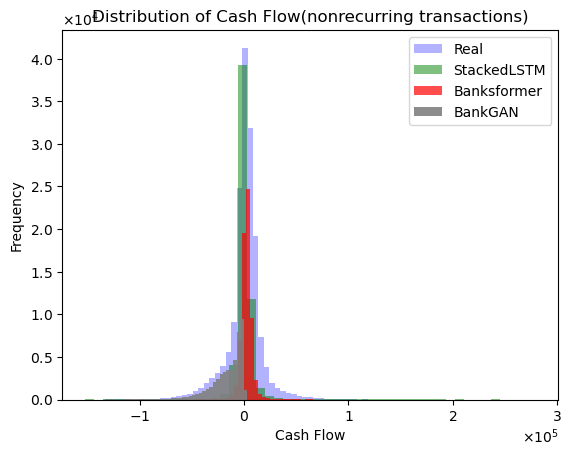

In [19]:
# Extract the 'cash flow' column from each dataset
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

cf_norec_synthbf = norec_synthbf_cf['raw_amount']
cf_norec_synthlstm = norec_synthlstm_cf['raw_amount']
cf_norec_real = norec_real_cf['raw_amount']
cf_norec_synthgan = norec_synthgan_cf['raw_amount']

# Plot histograms

plt.hist(cf_norec_real , bins=50, alpha=0.3,color='blue',label='Real')
plt.hist(cf_norec_synthlstm, bins=50, alpha=0.5,color='green',label='StackedLSTM')

plt.hist(cf_norec_synthbf, bins=50, alpha=0.7,color='red',label='Banksformer')
plt.hist(cf_norec_synthgan, bins=50, alpha=0.9, color='gray', label='BankGAN')


# Set the formatter for the x and y axes
x_formatter = ScalarFormatter(useMathText=True)
x_formatter.set_scientific(True)
x_formatter.set_powerlimits((-3,3))

y_formatter = ScalarFormatter(useMathText=True)
y_formatter.set_scientific(True)
y_formatter.set_powerlimits((-3,3))

plt.gca().xaxis.set_major_formatter(x_formatter)
plt.gca().yaxis.set_major_formatter(y_formatter)

# Axis labels, legend, and title
plt.xlabel('Cash Flow')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.title('Distribution of Cash Flow(nonrecurring transactions)')

# Show the plot
plt.show()


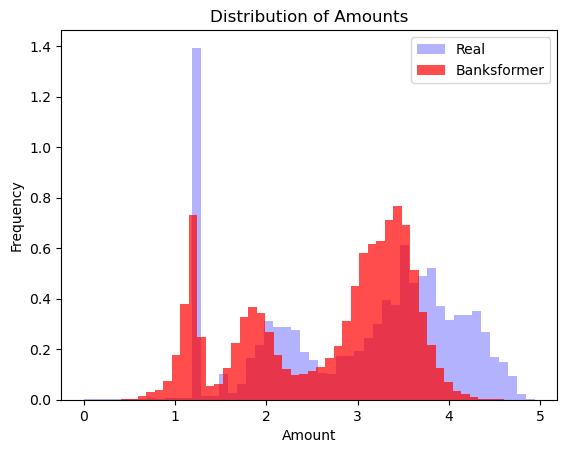

In [46]:
import matplotlib.pyplot as plt
# Extract the 'amount' column from each dataset
amt_synthbf = np.log10(all_synthbf['amount'] + 1)
amt_real = np.log10(all_real['amount']+ 1)


# Plot histograms
plt.hist(amt_real, bins=50, alpha=0.3,color='blue',density=True, label='Real')
plt.hist(amt_synthbf, bins=50, alpha=0.7,color='red',density=True, label='Banksformer')


plt.xlabel('Amount')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.title('Distribution of Amounts')
plt.show()

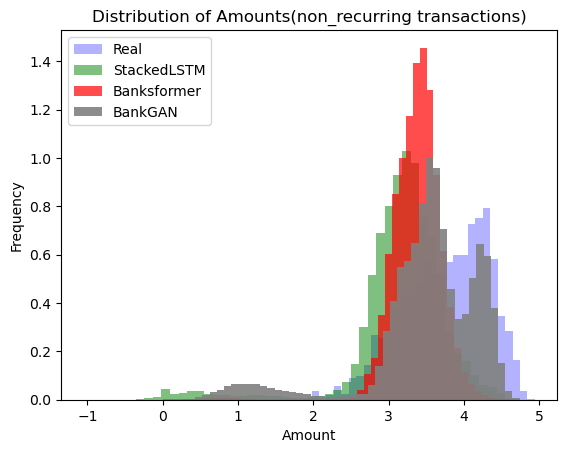

In [22]:
import matplotlib.pyplot as plt
# Extract the 'amount' column from each dataset
amt_norec_synthbf = np.log10(norec_synthbf['amount'] + 1)
amt_norec_synthlstm = np.log10(norec_synthlstm['amount']+ 1)
amt_norec_real = np.log10(norec_real['amount']+ 1)
amt_norec_synthgan = np.log10(norec_synthgan['amount']+ 1)

# Plot histograms
plt.hist(amt_norec_real, bins=50, alpha=0.3,color='blue', density= True, label='Real')
plt.hist(amt_norec_synthlstm, bins=50, alpha=0.5,color='green',density=True ,label='StackedLSTM')
plt.hist(amt_norec_synthbf, bins=50, alpha=0.7,color='red', density=True, label='Banksformer')
plt.hist(amt_norec_synthgan, bins=50, alpha=0.9, color='gray',density=True, label='BankGAN')

plt.xlabel('Amount')
plt.ylabel('Frequency')
plt.legend(loc='upper left')
plt.title('Distribution of Amounts(non_recurring transactions)')
plt.show()

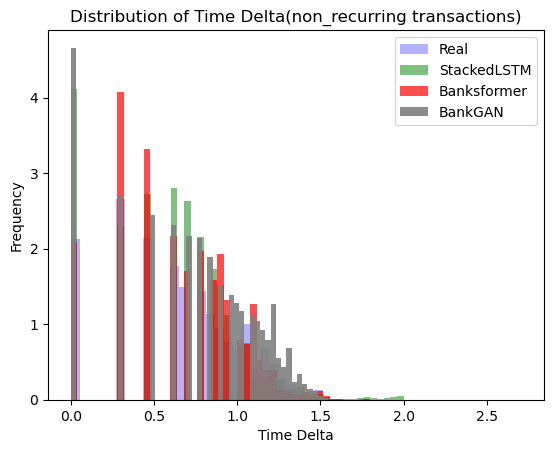

In [23]:
import matplotlib.pyplot as plt
# Extract the 'amount' column from each dataset
td_norec_synthbf = np.log10(norec_synthbf['td'] + 1)
td_norec_synthlstm = np.log10(norec_synthlstm['td']+ 1)
td_norec_real = np.log10(norec_real['td']+ 1)
td_norec_synthgan = np.log10(norec_synthgan['td']+ 1)

# Plot histograms
plt.hist(td_norec_real, bins=50, alpha=0.3,color='blue',density=True, label='Real')
plt.hist(td_norec_synthlstm, bins=50, alpha=0.5,color='green',density=True,  label='StackedLSTM')
plt.hist(td_norec_synthbf, bins=50, alpha=0.7,color='red', density=True, label='Banksformer')
plt.hist(td_norec_synthgan, bins=50, alpha=0.9, color='gray', density=True, label='BankGAN')

plt.xlabel('Time Delta')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.title('Distribution of Time Delta(non_recurring transactions)')
plt.show()

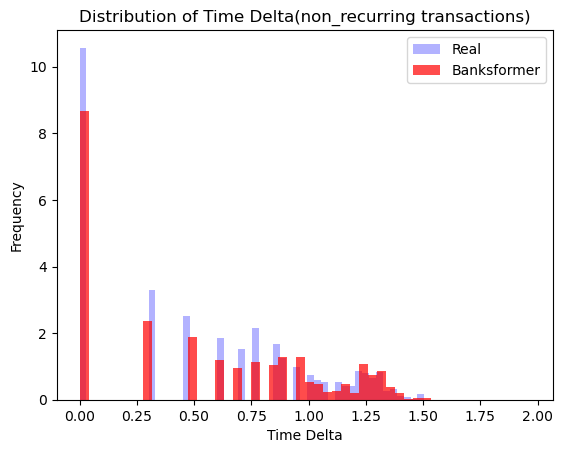

In [166]:
import matplotlib.pyplot as plt
#Extract the 'amount' column from each dataset
td_rec_synthbf = np.log10(rec_synthbf['td'] + 1)
td_rec_synthlstm = np.log10(rec_synthlstm['td']+ 1)
td_rec_real = np.log10(rec_real['td']+ 1)
td_rec_synthgan = np.log10(rec_synthgan['td']+ 1)

# td_rec_synthbf = rec_synthbf['td'] 
# td_rec_synthlstm = rec_synthlstm['td']
# td_rec_real = rec_real['td']
# td_rec_synthgan = rec_synthgan['td']


# Plot histograms
plt.hist(td_rec_real, bins=50, alpha=0.3,color='blue',density = True, label='Real')
#plt.hist(td_rec_synthlstm, bins=50, alpha=0.5,color='green',density = True, label='StackedLSTM')
plt.hist(td_rec_synthbf, bins=50, alpha=0.7,color='red',density = True, label='Banksformer')
#plt.hist(td_rec_synthgan, bins=50, alpha=0.9, color='gray',density = True, label='BankGAN')

plt.xlabel('Time Delta')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.title('Distribution of Time Delta(non_recurring transactions)')
plt.show()

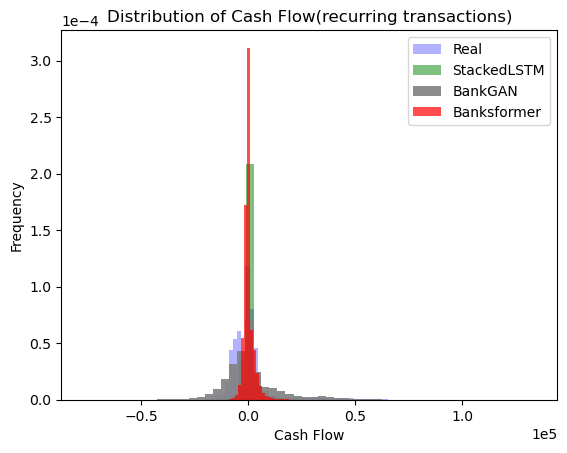

In [107]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter



# Plot histograms
plt.hist(cf_rec_real , bins=50, alpha=0.3, color='blue', density=True, label='Real')
plt.hist(cf_rec_synthlstm, bins=50, alpha=0.5, color='green', density=True, label='StackedLSTM')
plt.hist(cf_rec_synthgan, bins=50, alpha=0.9, color='gray', density=True, label='BankGAN')
plt.hist(cf_rec_synthbf, bins=50, alpha=0.7, color='red', density=True, label='Banksformer')


# Apply the custom formatter to the x and y axes
y_formatter = ScalarFormatter(useOffset=True)
y_formatter.set_scientific(True)
y_formatter.set_powerlimits((-3,3))

x_formatter = ScalarFormatter(useOffset=True)
x_formatter.set_scientific(True)
x_formatter.set_powerlimits((-3,3))

plt.gca().xaxis.set_major_formatter(x_formatter)
plt.gca().yaxis.set_major_formatter(y_formatter)

# Axis labels, legend, and title
plt.xlabel('Cash Flow')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.title('Distribution of Cash Flow(recurring transactions)')

# Show the plot with updated formatters
plt.show()


In [20]:
rec_real

,account_id,tcode,datetime,amount,td,month,year,type,raw_amount
1,1,CREDIT__COLLECTION FROM ANOTHER BANK__nan,1995-04-13,3679.0,20.0,4,1995,CREDIT,3679.0
3,1,CREDIT__nan__INTEREST CREDITED,1995-04-30,19.2,7.0,4,1995,CREDIT,19.2
4,1,CREDIT__COLLECTION FROM ANOTHER BANK__nan,1995-05-13,3679.0,13.0,5,1995,CREDIT,3679.0
6,1,CREDIT__nan__INTEREST CREDITED,1995-05-31,79.0,8.0,5,1995,CREDIT,79.0
7,1,CREDIT__COLLECTION FROM ANOTHER BANK__nan,1995-06-13,3679.0,13.0,6,1995,CREDIT,3679.0
...,...,...,...,...,...,...,...,...,...
1056313,11382,CREDIT__nan__INTEREST CREDITED,1998-11-30,240.4,0.0,11,1998,CREDIT,240.4
1056314,11382,CREDIT__nan__INTEREST CREDITED,1998-11-30,178.7,0.0,11,1998,CREDIT,178.7
1056316,11382,CREDIT__COLLECTION FROM ANOTHER BANK__nan,1998-12-10,46248.0,8.0,12,1998,CREDIT,46248.0
1056318,11382,CREDIT__nan__INTEREST CREDITED,1998-12-31,311.3,6.0,12,1998,CREDIT,311.3


In [19]:
cf_synthbf = all_synthbf_cf['raw_amount']
cf_synthlstm = all_synthlstm_cf['raw_amount']
cf_real = all_real_cf['raw_amount']
cf_synthgan = all_synthgan_cf['raw_amount']

hist_cf_real, bin_edges = np.histogram(cf_real, bins=50, density=True)
hist_cf_synthbf, _ = np.histogram(cf_synthbf, bins=50, density=True)
hist_cf_synthlstm, _ = np.histogram(cf_synthlstm, bins=50, density=True)
hist_cf_synthgan, _ = np.histogram(cf_synthgan, bins=50, density=True)

max_density_cf_real = np.max(hist_cf_real)
max_density_cf_synthbf = np.max(hist_cf_synthbf)
max_density_cf_synthlstm = np.max(hist_cf_synthlstm)
max_density_cf_synthgan = np.max(hist_cf_synthgan)


day_real = all_real['day'].value_counts().sort_values(ascending=False)
day_synthbf = all_synthbf['day'].value_counts().reindex(day_real.index, fill_value=0)
day_synthlstm = all_synthlstm['day'].value_counts().reindex(day_real.index, fill_value=0)
day_synthgan = all_synthgan['day'].value_counts().reindex(day_real.index, fill_value=0)

day_real_norm = day_real / day_real.sum()
day_synthbf_norm = day_synthbf / day_synthbf.sum()
day_synthlstm_norm = day_synthlstm / day_synthlstm.sum()
day_synthgan_norm = day_synthgan / day_synthgan.sum()

tcode_real = all_real['tcode'].value_counts().sort_values(ascending=False)
tcode_synthbf = all_synthbf['tcode'].value_counts().reindex(tcode_real.index, fill_value=0)
tcode_synthlstm = all_synthlstm['tcode'].value_counts().reindex(tcode_real.index, fill_value=0)
tcode_synthgan = all_synthgan['tcode'].value_counts().reindex(tcode_real.index, fill_value=0)

tcode_real_norm = tcode_real / tcode_real.sum()
tcode_synthbf_norm = tcode_synthbf / tcode_synthbf.sum()
tcode_synthlstm_norm = tcode_synthlstm / tcode_synthlstm.sum()
tcode_synthgan_norm = tcode_synthgan / tcode_synthgan.sum()

amt_synthbf = np.log10(all_synthbf['amount'] + 1)
amt_synthlstm = np.log10(all_synthlstm['amount']+ 1)
amt_real = np.log10(all_real['amount']+ 1)
amt_synthgan = np.log10(all_synthgan['amount']+ 1)

hist_amt_real, bin_edges = np.histogram(amt_real, bins=50, density=True)
hist_amt_synthbf, _ = np.histogram(amt_synthbf, bins=50, density=True)
hist_amt_synthlstm, _ = np.histogram(amt_synthlstm, bins=50, density=True)
hist_amt_synthgan, _ = np.histogram(amt_synthgan, bins=50, density=True)

max_density_amt_real = np.max(hist_amt_real)
max_density_amt_synthbf = np.max(hist_amt_synthbf)
max_density_amt_synthlstm = np.max(hist_amt_synthlstm)
max_density_amt_synthgan = np.max(hist_amt_synthgan)  


td_synthbf = np.log10(all_synthbf['td'] + 1)
td_synthlstm = np.log10(all_synthlstm['td']+ 1)
td_real = np.log10(all_real['td']+ 1)
td_synthgan = np.log10(all_synthgan['td']+ 1)


In [46]:
cf_rec_synthbf = rec_synthbf_cf['raw_amount']
cf_rec_synthlstm = rec_synthlstm_cf['raw_amount']
cf_rec_real = rec_real_cf['raw_amount']
cf_rec_synthgan = rec_synthgan_cf['raw_amount']



hist_cf_rec_real, bin_edges = np.histogram(cf_rec_real, bins=50, density=True)
hist_cf_rec_synthbf, _ = np.histogram(cf_rec_synthbf, bins=50, density=True)
hist_cf_rec_synthlstm, _ = np.histogram(cf_rec_synthlstm, bins=50, density=True)
hist_cf_rec_synthgan, _ = np.histogram(cf_rec_synthgan, bins=50, density=True)

max_density_cf_rec_real = np.max(hist_cf_rec_real)
max_density_cf_rec_synthbf = np.max(hist_cf_rec_synthbf)
max_density_cf_rec_synthlstm = np.max(hist_cf_rec_synthlstm)
max_density_cf_rec_synthgan = np.max(hist_cf_rec_synthgan)



cf_norec_synthbf = norec_synthbf_cf['raw_amount']
cf_norec_synthlstm = norec_synthlstm_cf['raw_amount']
cf_norec_real = norec_real_cf['raw_amount']
cf_norec_synthgan = norec_synthgan_cf['raw_amount']




hist_cf_norec_real, bin_edges = np.histogram(cf_norec_real, bins=50, density=True)
hist_cf_norec_synthbf, _ = np.histogram(cf_norec_synthbf, bins=50, density=True)
hist_cf_norec_synthlstm, _ = np.histogram(cf_norec_synthlstm, bins=50, density=True)
hist_cf_norec_synthgan, _ = np.histogram(cf_norec_synthgan, bins=50, density=True)

max_density_cf_norec_real = np.max(hist_cf_norec_real)
max_density_cf_norec_synthbf = np.max(hist_cf_norec_synthbf)
max_density_cf_norec_synthlstm = np.max(hist_cf_norec_synthlstm)
max_density_cf_norec_synthgan = np.max(hist_cf_norec_synthgan)


day_rec_real = rec_real['day'].value_counts().sort_values(ascending=False)
day_rec_synthbf = rec_synthbf['day'].value_counts().reindex(day_rec_real.index, fill_value=0)
day_rec_synthlstm = rec_synthlstm['day'].value_counts().reindex(day_rec_real.index, fill_value=0)
day_rec_synthgan = rec_synthgan['day'].value_counts().reindex(day_rec_real.index, fill_value=0)

day_rec_real_norm = day_rec_real / day_rec_real.sum()
day_rec_synthbf_norm = day_rec_synthbf / day_rec_synthbf.sum()
day_rec_synthlstm_norm = day_rec_synthlstm / day_rec_synthlstm.sum()
day_rec_synthgan_norm = day_rec_synthgan / day_rec_synthgan.sum()


day_norec_real = norec_real['day'].value_counts().sort_values(ascending=False)
day_norec_synthbf = norec_synthbf['day'].value_counts().reindex(tcode_norec_real.index, fill_value=0)
day_norec_synthlstm = norec_synthlstm['day'].value_counts().reindex(tcode_norec_real.index, fill_value=0)
day_norec_synthgan = norec_synthgan['day'].value_counts().reindex(tcode_norec_real.index, fill_value=0)

day_norec_real_norm = day_norec_real / day_norec_real.sum()
day_norec_synthbf_norm = day_norec_synthbf / day_norec_synthbf.sum()
day_norec_synthlstm_norm = day_norec_synthlstm / day_norec_synthlstm.sum()
day_norec_synthgan_norm = day_norec_synthgan / day_norec_synthgan.sum()






tcode_rec_real = rec_real['tcode'].value_counts().sort_values(ascending=False)
tcode_rec_synthbf = rec_synthbf['tcode'].value_counts().reindex(tcode_rec_real.index, fill_value=0)
tcode_rec_synthlstm = rec_synthlstm['tcode'].value_counts().reindex(tcode_rec_real.index, fill_value=0)
tcode_rec_synthgan = rec_synthgan['tcode'].value_counts().reindex(tcode_rec_real.index, fill_value=0)

tcode_rec_real_norm = tcode_rec_real / tcode_rec_real.sum()
tcode_rec_synthbf_norm = tcode_rec_synthbf / tcode_rec_synthbf.sum()
tcode_rec_synthlstm_norm = tcode_rec_synthlstm / tcode_rec_synthlstm.sum()
tcode_rec_synthgan_norm = tcode_rec_synthgan / tcode_rec_synthgan.sum()


tcode_norec_real = norec_real['tcode'].value_counts().sort_values(ascending=False)
tcode_norec_synthbf = norec_synthbf['tcode'].value_counts().reindex(tcode_norec_real.index, fill_value=0)
tcode_norec_synthlstm = norec_synthlstm['tcode'].value_counts().reindex(tcode_norec_real.index, fill_value=0)
tcode_norec_synthgan = norec_synthgan['tcode'].value_counts().reindex(tcode_norec_real.index, fill_value=0)

tcode_norec_real_norm = tcode_norec_real / tcode_norec_real.sum()
tcode_norec_synthbf_norm = tcode_norec_synthbf / tcode_norec_synthbf.sum()
tcode_norec_synthlstm_norm = tcode_norec_synthlstm / tcode_norec_synthlstm.sum()
tcode_norec_synthgan_norm = tcode_norec_synthgan / tcode_norec_synthgan.sum()


amt_rec_synthbf = np.log10(rec_synthbf['amount'] + 1)
amt_rec_synthlstm = np.log10(rec_synthlstm['amount']+ 1)
amt_rec_real = np.log10(rec_real['amount']+ 1)
amt_rec_synthgan = np.log10(rec_synthgan['amount']+ 1)

hist_amt_rec_real, bin_edges = np.histogram(amt_rec_real, bins=50, density=True)
hist_amt_rec_synthbf, _ = np.histogram(amt_rec_synthbf, bins=50, density=True)
hist_amt_rec_synthlstm, _ = np.histogram(amt_rec_synthlstm, bins=50, density=True)
hist_amt_rec_synthgan, _ = np.histogram(amt_rec_synthgan, bins=50, density=True)

max_density_amt_rec_real = np.max(hist_amt_rec_real)
max_density_amt_rec_synthbf = np.max(hist_amt_rec_synthbf)
max_density_amt_rec_synthlstm = np.max(hist_amt_rec_synthlstm)
max_density_amt_rec_synthgan = np.max(hist_amt_rec_synthgan)  

amt_norec_synthbf = np.log10(norec_synthbf['amount'] + 1)
amt_norec_synthlstm = np.log10(norec_synthlstm['amount']+ 1)
amt_norec_real = np.log10(norec_real['amount']+ 1)
amt_norec_synthgan = np.log10(norec_synthgan['amount']+ 1)


hist_amt_norec_real, bin_edges = np.histogram(amt_norec_real, bins=50, density=True)
hist_amt_norec_synthbf, _ = np.histogram(amt_norec_synthbf, bins=50, density=True)
hist_amt_norec_synthlstm, _ = np.histogram(amt_norec_synthlstm, bins=50, density=True)
hist_amt_norec_synthgan, _ = np.histogram(amt_norec_synthgan, bins=50, density=True)

max_density_amt_norec_real = np.max(hist_amt_norec_real)
max_density_amt_norec_synthbf = np.max(hist_amt_norec_synthbf)
max_density_amt_norec_synthlstm = np.max(hist_amt_norec_synthlstm)
max_density_amt_norec_synthgan = np.max(hist_amt_norec_synthgan)     


td_rec_synthbf = np.log10(rec_synthbf['td'] + 1)
td_rec_synthlstm = np.log10(rec_synthlstm['td']+ 1)
td_rec_real = np.log10(rec_real['td']+ 1)
td_rec_synthgan = np.log10(rec_synthgan['td']+ 1)

td_norec_synthbf = np.log10(norec_synthbf['td'] + 1)
td_norec_synthlstm = np.log10(norec_synthlstm['td']+ 1)
td_norec_real = np.log10(norec_real['td']+ 1)
td_norec_synthgan = np.log10(norec_synthgan['td']+ 1)



In [15]:
max(tcode_rec_real_norm)

0.2989835987950135

In [43]:
tcode_rec_real

CREDIT__nan__INTEREST CREDITED                           183114
DEBIT__CASH WITHDRAWAL__PAYMENT ON STATEMENT             155832
DEBIT__REMITTANCE TO ANOTHER BANK__HOUSEHOLD             115254
DEBIT__REMITTANCE TO ANOTHER BANK__                       52817
CREDIT__COLLECTION FROM ANOTHER BANK__nan                 34888
CREDIT__COLLECTION FROM ANOTHER BANK__OLD AGE PENSION     30338
DEBIT__REMITTANCE TO ANOTHER BANK__INSURANCE PAYMENT      18477
DEBIT__REMITTANCE TO ANOTHER BANK__LOAN PAYMENT           13580
DEBIT__REMITTANCE TO ANOTHER BANK__nan                     8155
Name: tcode, dtype: int64

In [53]:
# Split the index and create a new index
new_index = []
counter = {'CREDIT': 1, 'DEBIT': 1}  # Initialize counter for CREDIT and DEBIT

for index in tcode_norec_real.index:
    parts = index.split('__')
    if parts[0] in counter:  # Check if the first part is CREDIT or DEBIT
        new_index_name = f"{parts[0]}_{counter[parts[0]]}"  # Create new index name
        counter[parts[0]] += 1  # Increment counter for CREDIT or DEBIT
    else:
        new_index_name = index  # Use the original index name if not CREDIT or DEBIT
    new_index.append(new_index_name)

tcode_norec_real.index = new_index  # Assign the new index to the series

In [54]:
tcode_norec_real

DEBIT_1     274059
CREDIT_1    156743
DEBIT_2       8036
DEBIT_3       2811
DEBIT_4       1577
DEBIT_5        616
DEBIT_6         23
Name: tcode, dtype: int64

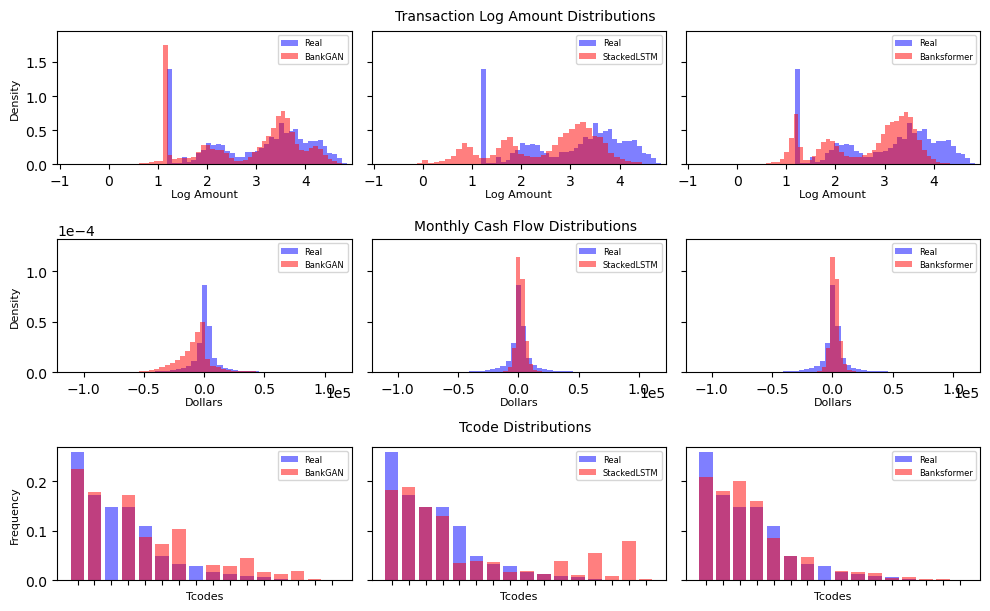

In [20]:
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

y_formatter = ScalarFormatter(useOffset=True)
y_formatter.set_scientific(True)
y_formatter.set_powerlimits((-3,3))

x_formatter = ScalarFormatter(useOffset=True)
x_formatter.set_scientific(True)
x_formatter.set_powerlimits((-3,3))

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10, 6))



# First Row: Amount
x_min = min(np.min(amt_real), np.min(amt_synthgan), np.min(amt_synthlstm), np.min(amt_synthbf))
x_max = max(np.max(amt_real), np.max(amt_synthgan), np.max(amt_synthlstm), np.max(amt_synthbf))

axes[0, 0].hist(amt_real, bins=50, alpha=0.5, color='blue', density=True, label='Real')
axes[0, 0].hist(amt_synthgan, bins=50, alpha=0.5, color='red', density=True, label='BankGAN')
axes[0, 0].set_xlim(x_min, x_max)
axes[0, 0].legend(loc='upper right', fontsize=6)
axes[0, 0].set_ylabel('Density', fontsize=8)
axes[0, 0].set_xlabel('Log Amount', fontsize=8, labelpad=0.7)


axes[0, 1].hist(amt_real, bins=50, alpha=0.5, color='blue', density=True, label='Real')
axes[0, 1].hist(amt_synthlstm, bins=50, alpha=0.5, color='red', density=True, label='StackedLSTM')
axes[0, 1].set_xlim(x_min, x_max)
axes[0, 1].legend(loc='upper right', fontsize=6)
axes[0, 1].set_yticklabels([])
axes[0, 1].set_xlabel('Log Amount', fontsize=8, labelpad=0.7)

axes[0, 2].hist(amt_real, bins=50, alpha=0.5, color='blue', density=True, label='Real')
axes[0, 2].hist(amt_synthbf, bins=50, alpha=0.5, color='red', density=True, label='Banksformer')
axes[0, 2].set_xlim(x_min, x_max)
axes[0, 2].set_xlabel('Log Amount', fontsize=8, labelpad=0.7)
axes[0, 2].legend(loc='upper right', fontsize=6)
axes[0, 2].set_yticklabels([])

y_min = 0  
y_max_amt = max([max_density_amt_real, max_density_amt_synthgan, max_density_amt_synthlstm, max_density_amt_synthbf])
axes[0, 0].set_ylim(y_min, y_max_amt + 0.2)
axes[0, 1].set_ylim(y_min, y_max_amt +0.2)
axes[0, 2].set_ylim(y_min, y_max_amt +0.2)



#second row: cash flow
x_min2 = min(np.min(cf_real), np.min(cf_synthgan), np.min(cf_synthlstm), np.min(cf_synthbf))
x_max2 = max(np.max(cf_real), np.max(cf_synthgan), np.max(cf_synthlstm), np.max(cf_synthbf))

axes[1, 0].hist(cf_real , bins=50, alpha=0.5, color='blue', density=True, label='Real')
axes[1, 0].hist(cf_synthgan, bins=50, alpha=0.5, color='red', density=True, label='BankGAN')
axes[1, 0].set_xlim(x_min2, x_max2)
axes[1, 0].xaxis.set_major_formatter(x_formatter)
axes[1, 0].yaxis.set_major_formatter(y_formatter)
offset_text = axes[1, 0].xaxis.get_offset_text()
offset_text.set_verticalalignment('bottom')
offset_text.set_horizontalalignment('right')
axes[1, 0].set_xlabel('Dollars', fontsize=8, labelpad=0.7)
axes[1, 0].set_ylabel('Density', fontsize=8)
axes[1, 0].legend(loc='upper right', fontsize=6)


axes[1, 1].hist(cf_real , bins=50, alpha=0.5, color='blue', density=True, label='Real')
axes[1, 1].hist(cf_synthlstm, bins=50, alpha=0.5, color='red', density=True, label='StackedLSTM')
axes[1, 1].set_xlim(x_min2, x_max2)
axes[1, 1].xaxis.set_major_formatter(x_formatter)
axes[1, 1].yaxis.set_major_formatter(y_formatter)
offset_text = axes[1, 1].xaxis.get_offset_text()
offset_text.set_verticalalignment('bottom')
offset_text.set_horizontalalignment('right')
axes[1, 1].set_xlabel('Dollars', fontsize=8, labelpad=0.7)
axes[1, 1].legend(loc='upper right', fontsize=6)
axes[1, 1].set_yticklabels([])
axes[1, 1].set_xlabel('Dollars', fontsize=8, labelpad=0.7)

axes[1, 2].hist(cf_real , bins=50, alpha=0.5, color='blue', density=True, label='Real')
axes[1, 2].hist(cf_synthbf, bins=50, alpha=0.5, color='red', density=True, label='Banksformer')
axes[1, 2].set_xlim(x_min2, x_max2)
axes[1, 2].xaxis.set_major_formatter(x_formatter)
axes[1, 2].yaxis.set_major_formatter(y_formatter)
offset_text = axes[1, 2].xaxis.get_offset_text()
offset_text.set_verticalalignment('bottom')
offset_text.set_horizontalalignment('right')
axes[1, 2].set_xlabel('Dollars', fontsize=8, labelpad=0.7)
axes[1, 2].legend(loc='upper right', fontsize=6)
axes[1, 2].set_yticklabels([])
axes[1, 2].set_xlabel('Dollars', fontsize=8, labelpad=0.7)

y_min = 0  
y_max_cf = max([max_density_cf_real, max_density_cf_synthgan, max_density_cf_synthlstm, max_density_cf_synthbf])

axes[1, 0].set_ylim(y_min, y_max_cf + 0.18e-4)
axes[1, 1].set_ylim(y_min, y_max_cf + 0.18e-4)
axes[1, 2].set_ylim(y_min, y_max_cf + 0.18e-4)


#Third Row: Transaction codes
positions = np.arange(len(tcode_real))
#positions = list(tcode_rec_real.index)
axes[2, 0].bar(positions, tcode_real_norm, alpha=0.5, color='blue', label='Real')
axes[2, 0].bar(positions, tcode_synthgan_norm, alpha=0.5, color='red', label='BankGAN')
axes[2, 0].set_xlabel('Tcodes', fontsize=8, labelpad=0.7)
axes[2, 0].set_ylabel('Frequency', fontsize=8)
axes[2, 0].set_xticks(positions)  
axes[2, 0].set_xticklabels([''] * len(positions)) 
axes[2, 0].legend(loc='upper right', fontsize=6)

axes[2, 1].bar(positions, tcode_real_norm, alpha=0.5, color='blue', label='Real')
axes[2, 1].bar(positions, tcode_synthlstm_norm, alpha=0.5, color='red', label='StackedLSTM')
axes[2, 1].set_xlabel('Tcodes', fontsize=8, labelpad=0.7)
axes[2, 1].set_xticks(positions)  
axes[2, 1].set_xticklabels([''] * len(positions))  
axes[2, 1].set_yticklabels([])
axes[2, 1].legend(loc='upper right', fontsize=6)


axes[2, 2].bar(positions, tcode_real_norm, alpha=0.5, color='blue', label='Real')
axes[2, 2].bar(positions, tcode_synthbf_norm, alpha=0.5, color='red', label='Banksformer')
axes[2, 2].set_xlabel('Tcodes', fontsize=8, labelpad=0.7)
axes[2, 2].set_xticks(positions)  
axes[2, 2].set_xticklabels([''] * len(positions))  
#axes[2, 2].set_xticklabels(positions, rotation=45, fontsize=6)
axes[2, 2].set_yticklabels([])
axes[2, 2].legend(loc='upper right', fontsize=6)


y_max_tcode = max([max(tcode_real_norm), max(tcode_synthbf_norm), max(tcode_synthlstm_norm), max(tcode_synthgan_norm)])
axes[2, 0].set_ylim(y_min, y_max_tcode + 0.01)
axes[2, 1].set_ylim(y_min, y_max_tcode + 0.01)
axes[2, 2].set_ylim(y_min, y_max_tcode + 0.01)



# Add a title for the first row
fig.text(0.53, 1, 'Transaction Log Amount Distributions', ha='center', va='center', fontsize=10)
# Add a title for the second row
fig.text(0.53, 0.65, 'Monthly Cash Flow Distributions', ha='center', va='center', fontsize=10)
# Add a title for the third row
fig.text(0.53, 0.315, 'Tcode Distributions', ha='center', va='center', fontsize=10)
# Add a title for the fourth row
#fig.text(0.5, 0.24, 'Log Time Delta Distributions', ha='center', va='center', fontsize=10)

fig.subplots_adjust()
fig.tight_layout(h_pad=1.8)

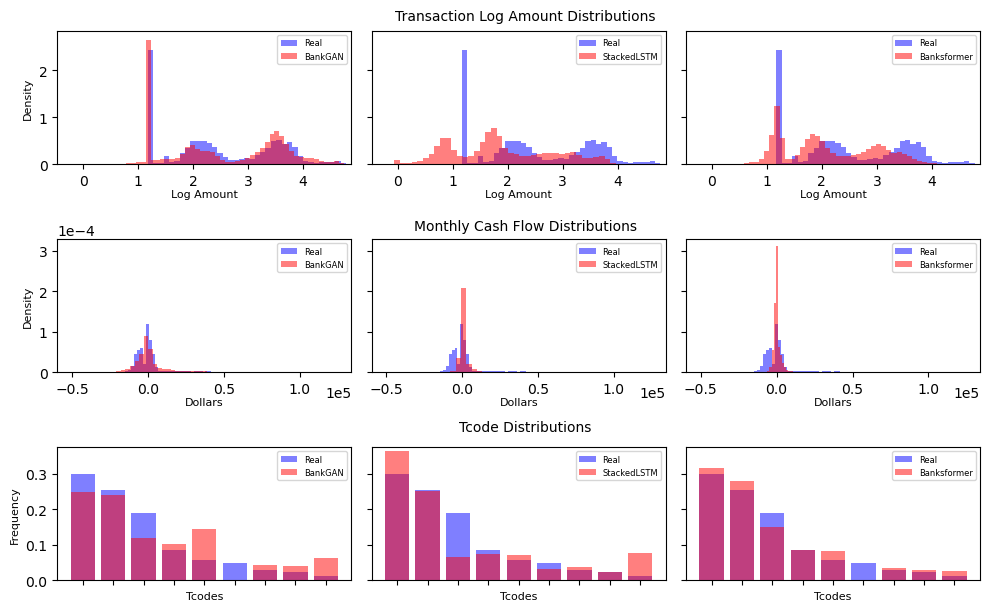

In [51]:
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

y_formatter = ScalarFormatter(useOffset=True)
y_formatter.set_scientific(True)
y_formatter.set_powerlimits((-3,3))

x_formatter = ScalarFormatter(useOffset=True)
x_formatter.set_scientific(True)
x_formatter.set_powerlimits((-3,3))

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10, 6))



# First Row: Amount
x_min = min(np.min(amt_rec_real), np.min(amt_rec_synthgan), np.min(amt_rec_synthlstm), np.min(amt_rec_synthbf))
x_max = max(np.max(amt_rec_real), np.max(amt_rec_synthgan), np.max(amt_rec_synthlstm), np.max(amt_rec_synthbf))

axes[0, 0].hist(amt_rec_real, bins=50, alpha=0.5, color='blue', density=True, label='Real')
axes[0, 0].hist(amt_rec_synthgan, bins=50, alpha=0.5, color='red', density=True, label='BankGAN')
axes[0, 0].set_xlim(x_min, x_max)
axes[0, 0].legend(loc='upper right', fontsize=6)
axes[0, 0].set_ylabel('Density', fontsize=8)
axes[0, 0].set_xlabel('Log Amount', fontsize=8, labelpad=0.7)


axes[0, 1].hist(amt_rec_real, bins=50, alpha=0.5, color='blue', density=True, label='Real')
axes[0, 1].hist(amt_rec_synthlstm, bins=50, alpha=0.5, color='red', density=True, label='StackedLSTM')
axes[0, 1].set_xlim(x_min, x_max)
axes[0, 1].legend(loc='upper right', fontsize=6)
axes[0, 1].set_yticklabels([])
axes[0, 1].set_xlabel('Log Amount', fontsize=8, labelpad=0.7)

axes[0, 2].hist(amt_rec_real, bins=50, alpha=0.5, color='blue', density=True, label='Real')
axes[0, 2].hist(amt_rec_synthbf, bins=50, alpha=0.5, color='red', density=True, label='Banksformer')
axes[0, 2].set_xlim(x_min, x_max)
axes[0, 2].set_xlabel('Log Amount', fontsize=8, labelpad=0.7)
axes[0, 2].legend(loc='upper right', fontsize=6)
axes[0, 2].set_yticklabels([])

y_min = 0  
y_max_amt_rec = max([max_density_amt_rec_real, max_density_amt_rec_synthgan, max_density_amt_rec_synthlstm, max_density_amt_rec_synthbf])
axes[0, 0].set_ylim(y_min, y_max_amt_rec + 0.2)
axes[0, 1].set_ylim(y_min, y_max_amt_rec +0.2)
axes[0, 2].set_ylim(y_min, y_max_amt_rec +0.2)



#second row: cash flow
x_min2 = min(np.min(cf_rec_real), np.min(cf_rec_synthgan), np.min(cf_rec_synthlstm), np.min(cf_rec_synthbf))
x_max2 = max(np.max(cf_rec_real), np.max(cf_rec_synthgan), np.max(cf_rec_synthlstm), np.max(cf_rec_synthbf))

axes[1, 0].hist(cf_rec_real , bins=50, alpha=0.5, color='blue', density=True, label='Real')
axes[1, 0].hist(cf_rec_synthgan, bins=50, alpha=0.5, color='red', density=True, label='BankGAN')
axes[1, 0].set_xlim(x_min2, x_max2)
axes[1, 0].xaxis.set_major_formatter(x_formatter)
axes[1, 0].yaxis.set_major_formatter(y_formatter)
offset_text = axes[1, 0].xaxis.get_offset_text()
offset_text.set_verticalalignment('bottom')
offset_text.set_horizontalalignment('right')
axes[1, 0].set_xlabel('Dollars', fontsize=8, labelpad=0.7)
axes[1, 0].set_ylabel('Density', fontsize=8)
axes[1, 0].legend(loc='upper right', fontsize=6)


axes[1, 1].hist(cf_rec_real , bins=50, alpha=0.5, color='blue', density=True, label='Real')
axes[1, 1].hist(cf_rec_synthlstm, bins=50, alpha=0.5, color='red', density=True, label='StackedLSTM')
axes[1, 1].set_xlim(x_min2, x_max2)
axes[1, 1].xaxis.set_major_formatter(x_formatter)
axes[1, 1].yaxis.set_major_formatter(y_formatter)
offset_text = axes[1, 1].xaxis.get_offset_text()
offset_text.set_verticalalignment('bottom')
offset_text.set_horizontalalignment('right')
axes[1, 1].set_xlabel('Dollars', fontsize=8, labelpad=0.7)
axes[1, 1].legend(loc='upper right', fontsize=6)
axes[1, 1].set_yticklabels([])
axes[1, 1].set_xlabel('Dollars', fontsize=8, labelpad=0.7)

axes[1, 2].hist(cf_rec_real , bins=50, alpha=0.5, color='blue', density=True, label='Real')
axes[1, 2].hist(cf_rec_synthbf, bins=50, alpha=0.5, color='red', density=True, label='Banksformer')
axes[1, 2].set_xlim(x_min2, x_max2)
axes[1, 2].xaxis.set_major_formatter(x_formatter)
axes[1, 2].yaxis.set_major_formatter(y_formatter)
offset_text = axes[1, 2].xaxis.get_offset_text()
offset_text.set_verticalalignment('bottom')
offset_text.set_horizontalalignment('right')
axes[1, 2].set_xlabel('Dollars', fontsize=8, labelpad=0.7)
axes[1, 2].legend(loc='upper right', fontsize=6)
axes[1, 2].set_yticklabels([])
axes[1, 2].set_xlabel('Dollars', fontsize=8, labelpad=0.7)

y_min = 0  
y_max_cf_rec = max([max_density_cf_rec_real, max_density_cf_rec_synthgan, max_density_cf_rec_synthlstm, max_density_cf_rec_synthbf])

axes[1, 0].set_ylim(y_min, y_max_cf_rec + 0.18e-4)
axes[1, 1].set_ylim(y_min, y_max_cf_rec + 0.18e-4)
axes[1, 2].set_ylim(y_min, y_max_cf_rec + 0.18e-4)


#Third Row: Transaction codes
positions = np.arange(len(tcode_rec_real))
#positions = list(tcode_rec_real.index)
axes[2, 0].bar(positions, tcode_rec_real_norm, alpha=0.5, color='blue', label='Real')
axes[2, 0].bar(positions, tcode_rec_synthgan_norm, alpha=0.5, color='red', label='BankGAN')
axes[2, 0].set_xlabel('Tcodes', fontsize=8, labelpad=0.7)
axes[2, 0].set_ylabel('Frequency', fontsize=8)
axes[2, 0].set_xticks(positions)  
axes[2, 0].set_xticklabels([''] * len(positions)) 
axes[2, 0].legend(loc='upper right', fontsize=6)

axes[2, 1].bar(positions, tcode_rec_real_norm, alpha=0.5, color='blue', label='Real')
axes[2, 1].bar(positions, tcode_rec_synthlstm_norm, alpha=0.5, color='red', label='StackedLSTM')
axes[2, 1].set_xlabel('Tcodes', fontsize=8, labelpad=0.7)
axes[2, 1].set_xticks(positions)  
axes[2, 1].set_xticklabels([''] * len(positions))  
axes[2, 1].set_yticklabels([])
axes[2, 1].legend(loc='upper right', fontsize=6)


axes[2, 2].bar(positions, tcode_rec_real_norm, alpha=0.5, color='blue', label='Real')
axes[2, 2].bar(positions, tcode_rec_synthbf_norm, alpha=0.5, color='red', label='Banksformer')
axes[2, 2].set_xlabel('Tcodes', fontsize=8, labelpad=0.7)
axes[2, 2].set_xticks(positions)  
axes[2, 2].set_xticklabels([''] * len(positions))  
#axes[2, 2].set_xticklabels(positions, rotation=45, fontsize=6)
axes[2, 2].set_yticklabels([])
axes[2, 2].legend(loc='upper right', fontsize=6)


y_max_tcode = max([max(tcode_rec_real_norm), max(tcode_rec_synthbf_norm), max(tcode_rec_synthlstm_norm), max(tcode_rec_synthgan_norm)])
axes[2, 0].set_ylim(y_min, y_max_tcode + 0.01)
axes[2, 1].set_ylim(y_min, y_max_tcode + 0.01)
axes[2, 2].set_ylim(y_min, y_max_tcode + 0.01)




# Third Row: Day of Month
# positions = np.arange(len(day_rec_real))
# axes[2, 0].bar(positions, day_rec_real_norm, alpha=0.5, color='blue', label='Real')
# axes[2, 0].bar(positions, day_rec_synthgan_norm, alpha=0.5, color='red', label='BankGAN')
# axes[2, 0].set_xlabel('Days', fontsize=8, labelpad=0.7)
# axes[2, 0].set_ylabel('Frequency', fontsize=8)
# axes[2, 0].set_xticks(positions)  # Set the positions for the ticks
# axes[2, 0].set_xticklabels([''] * len(positions))  # Set empty strings for the tick labels
# axes[2, 0].legend(loc='upper right', fontsize=6)

# axes[2, 1].bar(positions, day_rec_real_norm, alpha=0.5, color='blue', label='Real')
# axes[2, 1].bar(positions, day_rec_synthlstm_norm, alpha=0.5, color='red', label='StackedLSTM')
# axes[2, 1].set_xlabel('Days', fontsize=8, labelpad=0.7)
# axes[2, 1].set_xticks(positions)  # Set the positions for the ticks
# axes[2, 1].set_xticklabels([''] * len(positions))  # Set empty strings for the tick labels
# axes[2, 1].set_yticklabels([])
# axes[2, 1].legend(loc='upper right', fontsize=6)


# axes[2, 2].bar(positions, day_rec_real_norm, alpha=0.5, color='blue', label='Real')
# axes[2, 2].bar(positions, day_rec_synthbf_norm, alpha=0.5, color='red', label='Banksformer')
# axes[2, 2].set_xlabel('Days', fontsize=8, labelpad=0.7)
# axes[2, 2].set_xticks(positions)  # Set the positions for the ticks
# axes[2, 2].set_xticklabels([''] * len(positions))  # Set empty strings for the tick labels
# axes[2, 2].set_yticklabels([])
# axes[2, 2].legend(loc='upper right', fontsize=6)


# y_max_day = max([max(day_rec_real_norm), max(day_rec_synthbf_norm), max(day_rec_synthlstm_norm), max(day_rec_synthgan_norm)])
# axes[2, 0].set_ylim(y_min, y_max_day)
# axes[2, 1].set_ylim(y_min, y_max_day)
# axes[2, 2].set_ylim(y_min, y_max_day)

# x_min3 = min(np.min(td_rec_real), np.min(td_rec_synthgan), np.min(td_rec_synthlstm), np.min(td_rec_synthbf))
# x_max3 = max(np.max(td_rec_real), np.max(td_rec_synthgan), np.max(td_rec_synthlstm), np.max(td_rec_synthbf))

# axes[3, 0].hist(td_rec_real, bins=50, alpha=0.5, color='blue', density=True, label='Real')
# axes[3, 0].hist(td_rec_synthgan, bins=50, alpha=0.5, color='red', density=True, label='BankGAN')
# axes[3, 0].set_xlim(x_min3-0.1, x_max3 + 0.1)
# axes[3, 0].legend(loc='upper right', fontsize=6)
# axes[3, 0].set_ylabel('Density', fontsize=8)
# axes[3, 0].set_xlabel('Log Time Delta', fontsize=8, labelpad=0.7)


# axes[3, 1].hist(td_rec_real, bins=50, alpha=0.5, color='blue', density=True, label='Real')
# axes[3, 1].hist(td_rec_synthlstm, bins=50, alpha=0.5, color='red', density=True, label='StackedLSTM')
# axes[3, 1].set_xlim(x_min3-0.1, x_max3 + 0.1)
# axes[3, 1].legend(loc='upper right', fontsize=6)
# axes[3, 1].set_yticklabels([])
# axes[3, 1].set_xlabel('Log Time Delta', fontsize=8, labelpad=0.7)

# axes[3, 2].hist(td_rec_real, bins=50, alpha=0.5, color='blue', density=True, label='Real')
# axes[3, 2].hist(td_rec_synthbf, bins=50, alpha=0.5, color='red', density=True, label='Banksformer')
# axes[3, 2].set_xlim(x_min3-0.1, x_max3 + 0.1)
# axes[3, 2].legend(loc='upper right', fontsize=6)
# axes[3, 2].set_yticklabels([])
# axes[3, 2].set_xlabel('Log Time Delta', fontsize=8, labelpad=0.7)



# Add a title for the first row
fig.text(0.53, 1, 'Transaction Log Amount Distributions', ha='center', va='center', fontsize=10)
# Add a title for the second row
fig.text(0.53, 0.65, 'Monthly Cash Flow Distributions', ha='center', va='center', fontsize=10)
# Add a title for the third row
fig.text(0.53, 0.315, 'Tcode Distributions', ha='center', va='center', fontsize=10)
# Add a title for the fourth row
#fig.text(0.5, 0.24, 'Log Time Delta Distributions', ha='center', va='center', fontsize=10)

fig.subplots_adjust()
fig.tight_layout(h_pad=1.8)

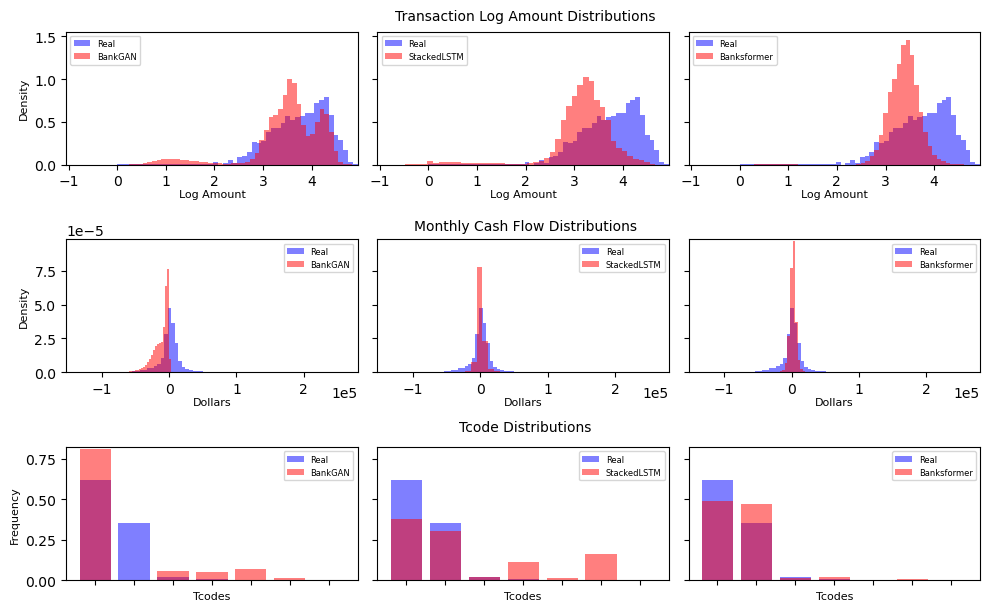

In [61]:
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

y_formatter = ScalarFormatter(useOffset=True)
y_formatter.set_scientific(True)
y_formatter.set_powerlimits((-3,3))

x_formatter = ScalarFormatter(useOffset=True)
x_formatter.set_scientific(True)
x_formatter.set_powerlimits((-3,3))

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10, 6))



# First Row: Amount
x_min = min(np.min(amt_norec_real), np.min(amt_norec_synthgan), np.min(amt_norec_synthlstm), np.min(amt_norec_synthbf))
x_max = max(np.max(amt_norec_real), np.max(amt_norec_synthgan), np.max(amt_norec_synthlstm), np.max(amt_norec_synthbf))

axes[0, 0].hist(amt_norec_real, bins=50, alpha=0.5, color='blue', density=True, label='Real')
axes[0, 0].hist(amt_norec_synthgan, bins=50, alpha=0.5, color='red', density=True, label='BankGAN')
axes[0, 0].set_xlim(x_min, x_max)
axes[0, 0].legend(loc='upper left', fontsize=6)
axes[0, 0].set_ylabel('Density', fontsize=8)
axes[0, 0].set_xlabel('Log Amount', fontsize=8, labelpad=0.7)


axes[0, 1].hist(amt_norec_real, bins=50, alpha=0.5, color='blue', density=True, label='Real')
axes[0, 1].hist(amt_norec_synthlstm, bins=50, alpha=0.5, color='red', density=True, label='StackedLSTM')
axes[0, 1].set_xlim(x_min, x_max)
axes[0, 1].legend(loc='upper left', fontsize=6)
axes[0, 1].set_yticklabels([])
axes[0, 1].set_xlabel('Log Amount', fontsize=8, labelpad=0.7)

axes[0, 2].hist(amt_norec_real, bins=50, alpha=0.5, color='blue', density=True, label='Real')
axes[0, 2].hist(amt_norec_synthbf, bins=50, alpha=0.5, color='red', density=True, label='Banksformer')
axes[0, 2].set_xlim(x_min, x_max)
axes[0, 2].set_xlabel('Log Amount', fontsize=8, labelpad=0.7)
axes[0, 2].legend(loc='upper left', fontsize=6)
axes[0, 2].set_yticklabels([])

y_min = 0  
y_max_amt_norec = max([max_density_amt_norec_real, max_density_amt_norec_synthgan, max_density_amt_norec_synthlstm, max_density_amt_norec_synthbf])
axes[0, 0].set_ylim(y_min, y_max_amt_norec + 0.1)
axes[0, 1].set_ylim(y_min, y_max_amt_norec +0.1)
axes[0, 2].set_ylim(y_min, y_max_amt_norec +0.1)



#second row: cash flow
x_min2 = min(np.min(cf_norec_real), np.min(cf_norec_synthgan), np.min(cf_norec_synthlstm), np.min(cf_norec_synthbf))
x_max2 = max(np.max(cf_norec_real), np.max(cf_norec_synthgan), np.max(cf_norec_synthlstm), np.max(cf_norec_synthbf))

axes[1, 0].hist(cf_norec_real , bins=50, alpha=0.5, color='blue', density=True, label='Real')
axes[1, 0].hist(cf_norec_synthgan, bins=50, alpha=0.5, color='red', density=True, label='BankGAN')
axes[1, 0].set_xlim(x_min2, x_max2)
axes[1, 0].xaxis.set_major_formatter(x_formatter)
axes[1, 0].yaxis.set_major_formatter(y_formatter)
offset_text = axes[1, 0].xaxis.get_offset_text()
offset_text.set_verticalalignment('bottom')
offset_text.set_horizontalalignment('right')
axes[1, 0].set_xlabel('Dollars', fontsize=8, labelpad=0.7)
axes[1, 0].set_ylabel('Density', fontsize=8)
axes[1, 0].legend(loc='upper right', fontsize=6)


axes[1, 1].hist(cf_norec_real , bins=50, alpha=0.5, color='blue', density=True, label='Real')
axes[1, 1].hist(cf_norec_synthlstm, bins=50, alpha=0.5, color='red', density=True, label='StackedLSTM')
axes[1, 1].set_xlim(x_min2, x_max2)
axes[1, 1].xaxis.set_major_formatter(x_formatter)
axes[1, 1].yaxis.set_major_formatter(y_formatter)
offset_text = axes[1, 1].xaxis.get_offset_text()
offset_text.set_verticalalignment('bottom')
offset_text.set_horizontalalignment('right')
axes[1, 1].set_xlabel('Dollars', fontsize=8, labelpad=0.7)
axes[1, 1].legend(loc='upper right', fontsize=6)
axes[1, 1].set_yticklabels([])
axes[1, 1].set_xlabel('Dollars', fontsize=8, labelpad=0.7)

axes[1, 2].hist(cf_norec_real , bins=50, alpha=0.5, color='blue', density=True, label='Real')
axes[1, 2].hist(cf_norec_synthbf, bins=50, alpha=0.5, color='red', density=True, label='Banksformer')
axes[1, 2].set_xlim(x_min2, x_max2)
axes[1, 2].xaxis.set_major_formatter(x_formatter)
axes[1, 2].yaxis.set_major_formatter(y_formatter)
offset_text = axes[1, 2].xaxis.get_offset_text()
offset_text.set_verticalalignment('bottom')
offset_text.set_horizontalalignment('right')
axes[1, 2].set_xlabel('Dollars', fontsize=8, labelpad=0.7)
axes[1, 2].legend(loc='upper right', fontsize=6)
axes[1, 2].set_yticklabels([])
axes[1, 2].set_xlabel('Dollars', fontsize=8, labelpad=0.7)

y_min = 0  
y_max_cf_norec = max([max_density_cf_norec_real, max_density_cf_norec_synthgan, max_density_cf_norec_synthlstm, max_density_cf_norec_synthbf])

axes[1, 0].set_ylim(y_min, y_max_cf_norec + 0.01e-4)
axes[1, 1].set_ylim(y_min, y_max_cf_norec + 0.01e-4)
axes[1, 2].set_ylim(y_min, y_max_cf_norec + 0.01e-4)


#Third Row: Transaction codes
#positions = np.arange(len(tcode_norec_real))
positions = list(tcode_norec_real.index)
axes[2, 0].bar(positions, tcode_norec_real_norm, alpha=0.5, color='blue', label='Real')
axes[2, 0].bar(positions, tcode_norec_synthgan_norm, alpha=0.5, color='red', label='BankGAN')
axes[2, 0].set_xlabel('Tcodes', fontsize=8, labelpad=0.7)
axes[2, 0].set_ylabel('Frequency', fontsize=8)
axes[2, 0].set_xticks(positions)  
#axes[2, 0].set_xticklabels(positions, rotation=45, fontsize=6)
axes[2, 0].set_xticklabels([''] * len(positions)) 
axes[2, 0].legend(loc='upper right', fontsize=6)

axes[2, 1].bar(positions, tcode_norec_real_norm, alpha=0.5, color='blue', label='Real')
axes[2, 1].bar(positions, tcode_norec_synthlstm_norm, alpha=0.5, color='red', label='StackedLSTM')
axes[2, 1].set_xlabel('Tcodes', fontsize=8, labelpad=0.7)
axes[2, 1].set_xticks(positions)  
axes[2, 1].set_xticklabels([''] * len(positions))  
axes[2, 1].set_yticklabels([])
axes[2, 1].legend(loc='upper right', fontsize=6)


axes[2, 2].bar(positions, tcode_norec_real_norm, alpha=0.5, color='blue', label='Real')
axes[2, 2].bar(positions, tcode_norec_synthbf_norm, alpha=0.5, color='red', label='Banksformer')
axes[2, 2].set_xlabel('Tcodes', fontsize=8, labelpad=0.7)
axes[2, 2].set_xticks(positions)  
axes[2, 2].set_xticklabels([''] * len(positions))  
axes[2, 2].set_yticklabels([])
axes[2, 2].legend(loc='upper right', fontsize=6)

# axes[2, 0].set_xticklabels(positions, rotation=45, fontsize=6)
# axes[2, 1].set_xticklabels(positions, rotation=45, fontsize=6)
# axes[2, 2].set_xticklabels(positions, rotation=45, fontsize=6)

y_max_tcode = max([max(tcode_norec_real_norm), max(tcode_norec_synthbf_norm), max(tcode_norec_synthlstm_norm), max(tcode_norec_synthgan_norm)])
axes[2, 0].set_ylim(y_min, y_max_tcode + 0.01)
axes[2, 1].set_ylim(y_min, y_max_tcode + 0.01)
axes[2, 2].set_ylim(y_min, y_max_tcode + 0.01)




# Third Row: Day of Month
# positions = np.arange(len(day_rec_real))
# axes[2, 0].bar(positions, day_rec_real_norm, alpha=0.5, color='blue', label='Real')
# axes[2, 0].bar(positions, day_rec_synthgan_norm, alpha=0.5, color='red', label='BankGAN')
# axes[2, 0].set_xlabel('Days', fontsize=8, labelpad=0.7)
# axes[2, 0].set_ylabel('Frequency', fontsize=8)
# axes[2, 0].set_xticks(positions)  # Set the positions for the ticks
# axes[2, 0].set_xticklabels([''] * len(positions))  # Set empty strings for the tick labels
# axes[2, 0].legend(loc='upper right', fontsize=6)

# axes[2, 1].bar(positions, day_rec_real_norm, alpha=0.5, color='blue', label='Real')
# axes[2, 1].bar(positions, day_rec_synthlstm_norm, alpha=0.5, color='red', label='StackedLSTM')
# axes[2, 1].set_xlabel('Days', fontsize=8, labelpad=0.7)
# axes[2, 1].set_xticks(positions)  # Set the positions for the ticks
# axes[2, 1].set_xticklabels([''] * len(positions))  # Set empty strings for the tick labels
# axes[2, 1].set_yticklabels([])
# axes[2, 1].legend(loc='upper right', fontsize=6)


# axes[2, 2].bar(positions, day_rec_real_norm, alpha=0.5, color='blue', label='Real')
# axes[2, 2].bar(positions, day_rec_synthbf_norm, alpha=0.5, color='red', label='Banksformer')
# axes[2, 2].set_xlabel('Days', fontsize=8, labelpad=0.7)
# axes[2, 2].set_xticks(positions)  # Set the positions for the ticks
# axes[2, 2].set_xticklabels([''] * len(positions))  # Set empty strings for the tick labels
# axes[2, 2].set_yticklabels([])
# axes[2, 2].legend(loc='upper right', fontsize=6)


# y_max_day = max([max(day_rec_real_norm), max(day_rec_synthbf_norm), max(day_rec_synthlstm_norm), max(day_rec_synthgan_norm)])
# axes[2, 0].set_ylim(y_min, y_max_day)
# axes[2, 1].set_ylim(y_min, y_max_day)
# axes[2, 2].set_ylim(y_min, y_max_day)

# x_min3 = min(np.min(td_rec_real), np.min(td_rec_synthgan), np.min(td_rec_synthlstm), np.min(td_rec_synthbf))
# x_max3 = max(np.max(td_rec_real), np.max(td_rec_synthgan), np.max(td_rec_synthlstm), np.max(td_rec_synthbf))

# axes[3, 0].hist(td_rec_real, bins=50, alpha=0.5, color='blue', density=True, label='Real')
# axes[3, 0].hist(td_rec_synthgan, bins=50, alpha=0.5, color='red', density=True, label='BankGAN')
# axes[3, 0].set_xlim(x_min3-0.1, x_max3 + 0.1)
# axes[3, 0].legend(loc='upper right', fontsize=6)
# axes[3, 0].set_ylabel('Density', fontsize=8)
# axes[3, 0].set_xlabel('Log Time Delta', fontsize=8, labelpad=0.7)


# axes[3, 1].hist(td_rec_real, bins=50, alpha=0.5, color='blue', density=True, label='Real')
# axes[3, 1].hist(td_rec_synthlstm, bins=50, alpha=0.5, color='red', density=True, label='StackedLSTM')
# axes[3, 1].set_xlim(x_min3-0.1, x_max3 + 0.1)
# axes[3, 1].legend(loc='upper right', fontsize=6)
# axes[3, 1].set_yticklabels([])
# axes[3, 1].set_xlabel('Log Time Delta', fontsize=8, labelpad=0.7)

# axes[3, 2].hist(td_rec_real, bins=50, alpha=0.5, color='blue', density=True, label='Real')
# axes[3, 2].hist(td_rec_synthbf, bins=50, alpha=0.5, color='red', density=True, label='Banksformer')
# axes[3, 2].set_xlim(x_min3-0.1, x_max3 + 0.1)
# axes[3, 2].legend(loc='upper right', fontsize=6)
# axes[3, 2].set_yticklabels([])
# axes[3, 2].set_xlabel('Log Time Delta', fontsize=8, labelpad=0.7)



# Add a title for the first row
fig.text(0.53, 1, 'Transaction Log Amount Distributions', ha='center', va='center', fontsize=10)
# Add a title for the second row
fig.text(0.53, 0.65, 'Monthly Cash Flow Distributions', ha='center', va='center', fontsize=10)
# Add a title for the third row
fig.text(0.53, 0.315, 'Tcode Distributions', ha='center', va='center', fontsize=10)
# Add a title for the fourth row
#fig.text(0.5, 0.24, 'Log Time Delta Distributions', ha='center', va='center', fontsize=10)

fig.subplots_adjust()
fig.tight_layout(h_pad=1.8)

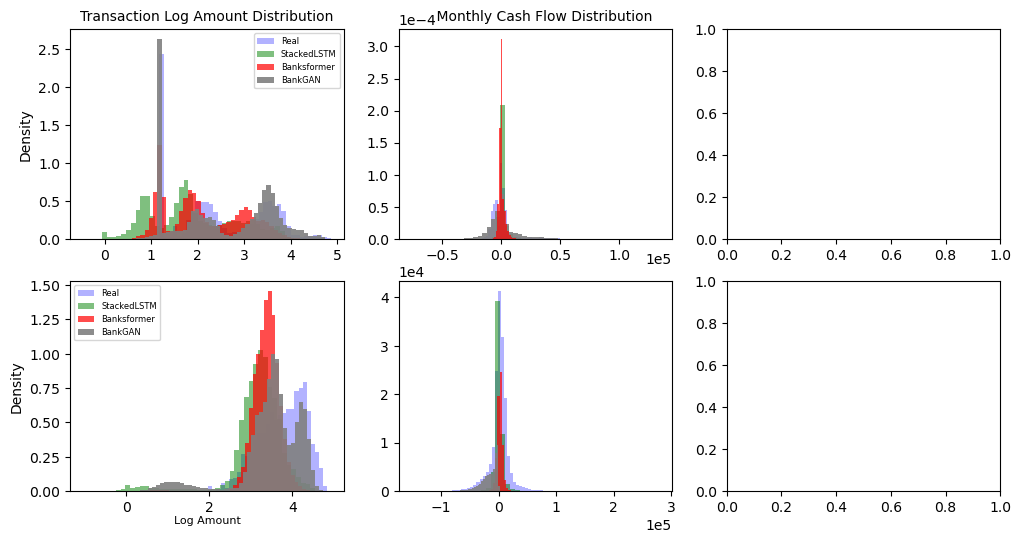

In [118]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 6))


axes[0, 0].hist(amt_rec_real, bins=50, alpha=0.3,color='blue',density=True, label='Real')
axes[0, 0].hist(amt_rec_synthlstm, bins=50, alpha=0.5,color='green',density=True, label='StackedLSTM')
axes[0, 0].hist(amt_rec_synthbf, bins=50, alpha=0.7,color='red',density=True, label='Banksformer')
axes[0, 0].hist(amt_rec_synthgan, bins=50, alpha=0.9, color='gray',density=True, label='BankGAN')

#axes[0, 0].set_xlabel('Log Amount')
axes[0, 0].set_ylabel('Density')
axes[0, 0].legend(loc='upper right', fontsize=6)
#axes[0, 0].label_outer()
axes[0, 0].set_title('Transaction Log Amount Distribution', fontsize=10)


axes[0, 1].hist(cf_rec_real , bins=50, alpha=0.3, color='blue', density=True, label='Real')
axes[0, 1].hist(cf_rec_synthlstm, bins=50, alpha=0.5, color='green', density=True, label='StackedLSTM')
axes[0, 1].hist(cf_rec_synthgan, bins=50, alpha=0.9, color='gray', density=True, label='BankGAN')
axes[0, 1].hist(cf_rec_synthbf, bins=50, alpha=0.7, color='red', density=True, label='Banksformer')


# Set the formatter for the x and y axes
x_formatter = ScalarFormatter(useOffset=True)
x_formatter.set_scientific(True)
x_formatter.set_powerlimits((-3,3))

y_formatter = ScalarFormatter(useOffset=True)
y_formatter.set_scientific(True)
y_formatter.set_powerlimits((-3,3))

axes[0, 1].xaxis.set_major_formatter(x_formatter)
axes[0, 1].yaxis.set_major_formatter(y_formatter)
offset_text = axes[0, 1].xaxis.get_offset_text()
offset_text.set_verticalalignment('bottom')
axes[0, 1].set_title('    Monthly Cash Flow Distribution', fontsize=10)



axes[1, 0].hist(amt_norec_real, bins=50, alpha=0.3,color='blue',density=True, label='Real')
axes[1, 0].hist(amt_norec_synthlstm, bins=50, alpha=0.5,color='green',density=True, label='StackedLSTM')
axes[1, 0].hist(amt_norec_synthbf, bins=50, alpha=0.7,color='red',density=True, label='Banksformer')
axes[1, 0].hist(amt_norec_synthgan, bins=50, alpha=0.9, color='gray',density=True, label='BankGAN')

axes[1, 0].set_xlabel('Log Amount', fontsize=8, labelpad=0.7)
axes[1, 0].set_ylabel('Density')
axes[1, 0].legend(loc='upper left', fontsize=6)


axes[1, 1].hist(cf_norec_real , bins=50, alpha=0.3,color='blue',label='Real')
axes[1, 1].hist(cf_norec_synthlstm, bins=50, alpha=0.5,color='green',label='StackedLSTM')

axes[1, 1].hist(cf_norec_synthbf, bins=50, alpha=0.7,color='red',label='Banksformer')
axes[1, 1].hist(cf_norec_synthgan, bins=50, alpha=0.9, color='gray', label='BankGAN')
axes[1, 1].xaxis.set_major_formatter(x_formatter)
axes[1, 1].yaxis.set_major_formatter(y_formatter)
offset_text = axes[0, 1].xaxis.get_offset_text()
offset_text.set_verticalalignment('bottom')

